In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import itertools as it
import subprocess as sp
import sys
import re
import collections
import json
import pysam
import enum
import bisect
import pgenlib as pg
import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt

import colorlog

In [2]:
%matplotlib inline

In [3]:
sys.path.append('../../../src/')

In [4]:
import misc
from read import read
from bim_file import bim_file
#from haplotype import Haplotype
from haplotype_block import haplotype_block
from population_reference import population_reference
from find_haplotypes_from_vcf import find_haplotypes_from_vcf

/home/ytanigaw/.conda/envs/pgenlib/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
logger = colorlog.getLogger()
logger.setLevel(colorlog.colorlog.logging.DEBUG)
handler = colorlog.StreamHandler()
handler.setFormatter(colorlog.ColoredFormatter())
logger.addHandler(handler)

In [6]:
logger.debug("Debug message")
logger.info("Information message")
logger.warning("Warning message")
logger.error("Error message")
logger.critical("Critical message")

DEBUG:root:Debug message
INFO:root:Information message
ERROR:root:Error message
CRITICAL:root:Critical message


## options are given as a json object

In [7]:
params = {
    'validataion_vcf':
      '/share/PI/mrivas/data/PlatinumGenomes/2016-1.0/hg19/small_variants/NA12878/NA12878.vcf.gz',
    'bam_file_name':
      '/share/PI/mrivas/data/nanopore-wgs-consortium/poretools_fastq.12894489.geq12500.bam',
    'fasta_ext':
      'fa',
    'ref_genome_template':
      '/share/PI/mrivas/data/hg19/chr${CHR}.${EXT}',
    'ref_population_template':
      '/share/PI/mrivas/data/1000genomes/ALL.chr${CHR}.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes-pgen.${EXT}'
}

In [8]:
json.dumps(params)

'{"bam_file_name": "/share/PI/mrivas/data/nanopore-wgs-consortium/poretools_fastq.12894489.geq12500.bam", "ref_genome_template": "/share/PI/mrivas/data/hg19/chr${CHR}.${EXT}", "validataion_vcf": "/share/PI/mrivas/data/PlatinumGenomes/2016-1.0/hg19/small_variants/NA12878/NA12878.vcf.gz", "ref_population_template": "/share/PI/mrivas/data/1000genomes/ALL.chr${CHR}.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes-pgen.${EXT}", "fasta_ext": "fa"}'

In [9]:
chromosome = 20

## need to look up file name for reference data
- misc.py

In [10]:
print misc.get_fasta_file_name(params, 20)
print misc.get_pgen_file_name(params, 20)
print misc.get_bim_file_name(params, 20)

/share/PI/mrivas/data/hg19/chr20.fa
/share/PI/mrivas/data/1000genomes/ALL.chr20.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes-pgen.pgen
/share/PI/mrivas/data/1000genomes/ALL.chr20.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes-pgen.bim


## Data structures for Nucleotide and Mismatch (on reads)

- misc.py

## reference genome

In [11]:
reference = pysam.FastaFile(misc.get_fasta_file_name(params, 20))

## bim file

- bim_file.py

In [12]:
bim = bim_file(params)
print bim.get_id(20)
print bim.get_bp(20)

['rs527639301' 'rs538242240' 'rs149529999' ..., 'rs563604166' 'rs577023641'
 'rs546194182']
[   60342    60418    60478 ..., 62965289 62965304 62965353]


In [13]:
print bim.find_index_interval(20, 60342, 60419)
print bim.find_index_interval(20, 60343, 60420)
print bim.find_index_interval(20, 60344, 60421)
print [x for x in range(1, 2)]

(0, 2)
(1, 2)
(1, 2)
[1]


## read bam file

- read.py

In [14]:
bamfile = pysam.AlignmentFile(filename = params['bam_file_name'], 
                              mode = 'rb')


In [15]:
#aligned_segment = bamfile.next()
aligned_segments = [bamfile.next() for i in range(10)]

In [16]:
r = read(aligned_segments[0], reference)

In [17]:
print(r)

chr20:59980-65177	5190	7	60	33ecb953-edd6-445b-87da-85c4551d8c8c_Basecall_Alignment_template


In [18]:
r.get_mismatches()

[Mismatch(reference_position=60992, reference=<Nucleotide.G: 2>, read=<Nucleotide.T: 3>, quality=14),
 Mismatch(reference_position=61171, reference=<Nucleotide.A: 0>, read=<Nucleotide.T: 3>, quality=14),
 Mismatch(reference_position=61220, reference=<Nucleotide.G: 2>, read=<Nucleotide.A: 0>, quality=17),
 Mismatch(reference_position=63344, reference=<Nucleotide.T: 3>, read=<Nucleotide.A: 0>, quality=15),
 Mismatch(reference_position=63377, reference=<Nucleotide.C: 1>, read=<Nucleotide.A: 0>, quality=16),
 Mismatch(reference_position=63378, reference=<Nucleotide.C: 1>, read=<Nucleotide.A: 0>, quality=16),
 Mismatch(reference_position=63798, reference=<Nucleotide.C: 1>, read=<Nucleotide.T: 3>, quality=15)]

In [19]:
r.get_mismatches_pos()

array([60992, 61171, 61220, 63344, 63377, 63378, 63798])

In [20]:
r.get_mismatches_polymorphic(bim)

array([], dtype=float64)

In [21]:
r.get_mismatches_polymorphic_pos(bim)

array([], dtype=float64)

#### read specific error rate

In [22]:
r.non_polymorphic_error_rate(bim=bim)

0.0011850681414181316

## pgen file for population reference
- haplotype.py
- population_reference.py

In [23]:
pgen = population_reference(params)

In [24]:
print(r)

chr20:59980-65177	5190	7	60	33ecb953-edd6-445b-87da-85c4551d8c8c_Basecall_Alignment_template


In [25]:
hb = haplotype_block(20, 60000, 65000, bim, pgen)

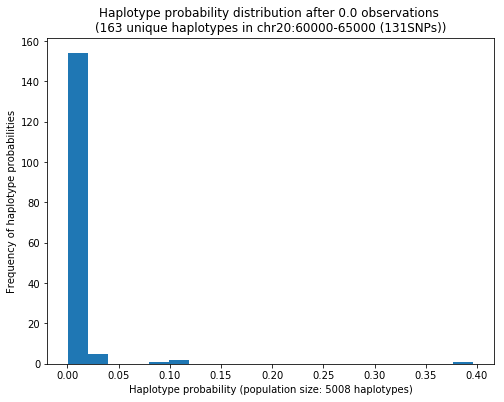

In [26]:
hb.plot()

In [27]:
hb.update_model_read_specific(r, bim)

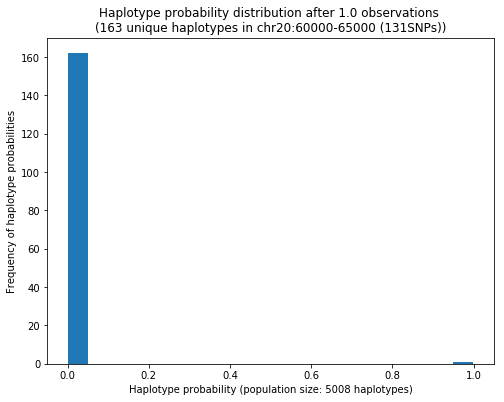

In [28]:
hb.plot()

In [104]:
hb = Haplotype_block(20, 0, 5000, bim, pgen)

In [108]:
bim.get_bp(20)[:10]

array([60342, 60418, 60478, 60521, 60567, 60570, 60578, 60648, 60777, 60794])

In [109]:
bim.get_bp(20)[-10:]

array([62965080, 62965099, 62965161, 62965166, 62965197, 62965213,
       62965214, 62965289, 62965304, 62965353])

In [110]:
(62965353 - 60342)/30000

2096

In [98]:
hb.map_value()

0.99960681871802282

In [101]:
hb.map_index()

array([0])

In [102]:
hb.haps[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

## define correct label for NA12878 data
- find_haplotypes_from_vcf.py

In [35]:
tbx = pysam.TabixFile(params['validataion_vcf'])

In [36]:
na12878_haps = find_haplotypes_from_vcf(tbx, bim, 20, 59980, 65117)

In [37]:
na12878_haps

array([[-9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9,  1, -9,  1, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9,  1, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9,  1, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9, -9, -9, -9, -9,  1, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9],
       [-9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9,  0, -9,  0, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9,  0, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9,  0, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9,
        -9, -9, -9, -9, -9,

# TODO
- manage haplotype block
  - partition bim file
- inference